In [1]:
#Import pandas, matplotlib.pyplot, and seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import os
import yfinance as yf
from tqdm import tqdm
%matplotlib inline
import scipy.stats
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from wordcloud import WordCloud, STOPWORDS
import random

In [2]:
myfold = os.getcwd()

In [3]:
company_list = pd.read_csv(myfold + '/raw_data/Company.csv')

In [4]:
company_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ticker_symbol  6 non-null      object
 1   company_name   6 non-null      object
dtypes: object(2)
memory usage: 224.0+ bytes


In [5]:
company_tweet = pd.read_csv(myfold + '/raw_data/Company_Tweet.csv')

In [6]:
company_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
dtypes: int64(1), object(1)
memory usage: 66.2+ MB


In [7]:
company_tweet.shape

(4336445, 2)

In [8]:
company_tweet.head()

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL


Let's look at number of tweets by ticker_symbol

In [9]:
tweet = pd.read_csv(myfold + '/raw_data/Tweet.csv')

In [10]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   tweet_id     int64 
 1   writer       object
 2   post_date    int64 
 3   body         object
 4   comment_num  int64 
 5   retweet_num  int64 
 6   like_num     int64 
dtypes: int64(5), object(2)
memory usage: 198.6+ MB


In [11]:
tweet.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


Now in order to associate the company with the tweet we can merge comapny_tweet and tweet dataframes 

In [12]:
tweet_combined = tweet.merge(company_tweet, on='tweet_id', how='inner')

In [13]:
tweet_combined.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL


Let us inspect tweet for any missing values

In [14]:
tweet_combined.isna().sum()

tweet_id             0
writer           55919
post_date            0
body                 0
comment_num          0
retweet_num          0
like_num             0
ticker_symbol        0
dtype: int64

We find that the writer column has a lot of missing values,as we are not planning to use this column and we ignore it.

The post_date is in form seconds since epoch. Covert it to a date object.

In [15]:
tweet_combined['post_date'] = pd.to_datetime(tweet_combined['post_date'], unit='s')

In [16]:
tweet_combined['Date'] = pd.to_datetime(tweet_combined['post_date'].dt.date)


In [17]:
tweet_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   tweet_id       int64         
 1   writer         object        
 2   post_date      datetime64[ns]
 3   body           object        
 4   comment_num    int64         
 5   retweet_num    int64         
 6   like_num       int64         
 7   ticker_symbol  object        
 8   Date           datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(3)
memory usage: 330.8+ MB


We do not need the twitter id any more.

In [18]:
tweet_combined = tweet_combined.drop(['tweet_id'],axis=1)

In [19]:
#Let's print out 100 random tweets to analyze better.

randomlist = random.sample(range(0, len(tweet_combined)), 100)

for i in tweet_combined.itertuples():
    if i[0] in randomlist:
        print(f"Tweet No. {i[0]}: {i[3]}")
    else:
        pass



Tweet No. 88749: APPLE - Fibonacci Technicals Levels - Intraday  Update - $AAPL #aapl http://stks.co/r1RYs
Tweet No. 115338: The #Mobile Payments Race Is On $AAPL $GOOG $GOOGL
Tweet No. 127479: lookn4wins: GOOG +0.47% Stock Charts $GOOG Google Inc. Cl C http://bit.ly/1aeda5V
Tweet No. 210975: $GOOG http://bit.ly Dimensions Of Flash And Storing The World http://ow.ly/2WAfzK
Tweet No. 288248: Morning brief: What BoC's Poloz said, and what it means http://stks.co/g2CRJ... $AAPL $ABX $ABX.CA $USDCAD $MACRO #cdnecon
Tweet No. 366455: JPM KaloBios Pharmaceuticals, Inc. Ask Sizehttp://dlvr.it/B235NM$JPM $CLLS $PEIX $AAPL #JPM #tradeideas #stocks
Tweet No. 369016: MY WATCHLIST  $TWC $AIG $ACT $MU $WFC $HTZ $LNG $CHTR $AAPL  http://bit.ly/1wbb89K
Tweet No. 369519: $TSLA follow the money aka follow the EMAs
Tweet No. 455674: Our Penny Stock Picks Have Gained 3,600% In 9 Months! Subscribe To Get Our Future Picks: http://tinyurl.com/ohqu6ql $ERBB $BBDA $GOOG
Tweet No. 462463: $AAPL 125P entry 1.40

Tweet No. 2331258: NASDAQ Stocks With 40M+ Shares Short: $MU $AAPL $OCLR $MSFT $CSCO $STX $MAT $BBRY $ASNA $PLUG
Tweet No. 2369755: Finally, if $AAPL isn't trading near $159/$160 as we head into Nov. 2 earnings, we will probably exit the trade as it will have been 6-weeks
Tweet No. 2405981: E-Commerce Titan Jeff Bezos (Amazon CEO) Talks Technology & Future Industries $AMZN http://ow.ly/Lc2D30gd4HB
Tweet No. 2427978: $AMZN - Amazon Announces New Baltimore County Fulfillment Center http://ih.advfn.com/p.php?pid=nmona&article=76045337&adw=1126416…
Tweet No. 2459985: Today´s pre-market trading https://finscreener.com/map $VZ $WMT $AMZN $GE $BAC $GOOGL $MSFT $PYPL $FB
Tweet No. 2498097: $AAPL a baloney downgrade as this is just ways to keep this from rising key support is 174 to 173 first we look at how 174 acts to give us more info. Big picture this want higher
Tweet No. 2593448:  $FUSZ STRONG INSIDER OWNERSHIP. GOTTA LOVE SKIN IN THE GAMEMORE DD: https://investorshangout.com/post/view?id=

To clean the above tweets, we need to do the following:

    Remove all the links starting with either http or pic.twitter.com or https
    Remove all the special characters, emoticons
    Remove all the hashtags (#), @ symbol.
    Remove all the numbers.

In [20]:
#Cleaning the tweets

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clean(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'pic.twitter\S+', ' ', text)
    text = decontracted(text)
    text = re.sub(r'\(([^)]+)\)', " ", text)
    text = text.replace('CraigScott31', ' ').replace('jimcramer', ' ').replace('CharlesNance415', ' ').replace('davidmoadel', ' ').replace('here is why', ' ')
    text = text.replace('markets update', ' ').replace('biznews', ' ').replace('click here', ' ').replace('live updates', ' ').replace('active traders', ' ')
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r' \w{1,2}_', ' ', text)
    text = re.sub('\s+',' ', text)
    return text

In [21]:
for i in tqdm(tweet_combined.itertuples()):
    tweet_combined.at[i[0], 'body'] = clean(i[3])

4336445it [02:42, 26666.80it/s]


In [22]:
tweet_combined.head()

,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,Date
0,VisualStockRSRC,2015-01-01 00:00:57,lx made on aapl check it out learn howtotrade ...,0,0,1,AAPL,2015-01-01
1,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling aapl ...,0,0,0,AAPL,2015-01-01
2,DozenStocks,2015-01-01 00:01:50,s p stocks performance hd low sbux tgt dvn ibm...,0,0,0,AMZN,2015-01-01
3,ShowDreamCar,2015-01-01 00:06:47,gm tsla volkswagen pushes record recall tally...,0,0,1,TSLA,2015-01-01
4,i_Know_First,2015-01-01 00:10:05,swing trading up to return in days swingtradin...,0,0,1,AAPL,2015-01-01


That's all we will be doing with our tweets dataset. We do not need to tokenize, remove stopwords, and get bigrams, etc because we will be using a pre-trained sentiment analyzer VADER here since our data is unsupervised.

Later on we will use  VADER for sentiment analysis as it works very well with social media text.

let's get the date of the oldest and the latest twitter post.

In [23]:
old_post_date = tweet_combined['Date'].min()
old_post_date

Timestamp('2015-01-01 00:00:00')

In [24]:
latest_post_date = tweet_combined['Date'].max()
latest_post_date

Timestamp('2019-12-31 00:00:00')

Let's check the Total number of tweets by ticker symbol

In [25]:
tweets_by_ticker =tweet_combined.ticker_symbol.value_counts()

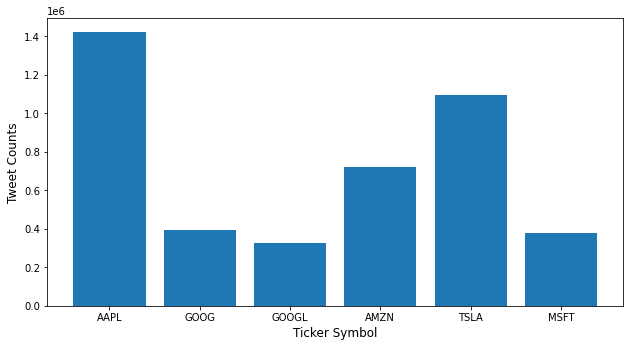

In [26]:
#Bar chart showing the tweets by ticker symbol
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Ticker Symbol",fontsize=12)
ax.set_ylabel("Tweet Counts",fontsize=12)
ticker = company_list['ticker_symbol']
count = tweets_by_ticker[company_list['ticker_symbol']]
ax.bar(ticker,count)
plt.show()

Let's look at the trend of tweets posted over the entire period for these ticker symbols.

In [27]:
tweets_by_month = tweet_combined.groupby(['ticker_symbol', 
                                      tweet_combined['post_date'].dt.to_period("M")]).size().reset_index()
tweets_by_month['post_date'] = tweets_by_month['post_date'].apply(lambda x: pd.to_datetime(str(x)))

In [28]:
tweets_by_month.rename(columns = {0:'tweet_count'},inplace = True)  
            

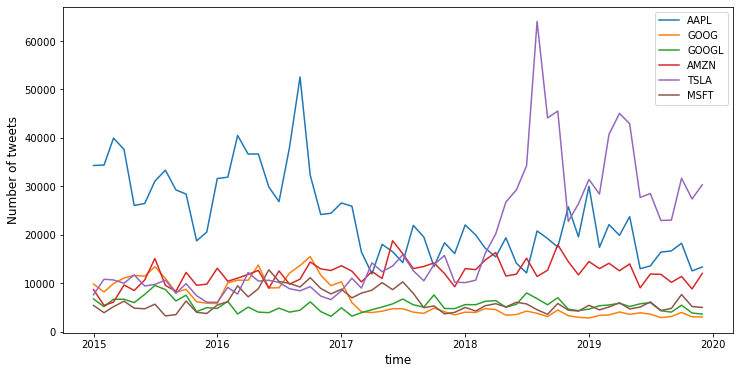

In [29]:
plt.figure(figsize=(12,6))
for ticker_symbol in company_list['ticker_symbol']:
    counts = tweets_by_month[tweets_by_month['ticker_symbol'] == ticker_symbol]
    plt.plot(counts['post_date'],counts['tweet_count'], label=ticker_symbol)

plt.legend()
plt.ylabel('Number of tweets',fontsize=12)
plt.xlabel("time",fontsize=12)
plt.show()  

We will get the historical stock price for all these stocks from yahoo finance

In [30]:
#Install yfinance using pip
!pip install yfinance

In [31]:
#get historical stock prices
stock_hist = pd.DataFrame()
stocks = ['TSLA','AAPL','GOOGL','GOOG','MSFT','AMZN']
for stock in stocks:
    info = yf.Ticker(stock).history(start=old_post_date, end=latest_post_date)
    info['ticker'] = stock
    stock_hist = stock_hist.append(info)


In [32]:
stock_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2015-01-02,44.574001,44.650002,42.652000,43.862000,23822000,0.0,0.0,TSLA
2015-01-05,42.910000,43.299999,41.431999,42.018002,26842500,0.0,0.0,TSLA
2015-01-06,42.012001,42.840000,40.841999,42.256001,31309500,0.0,0.0,TSLA
2015-01-07,42.669998,42.956001,41.956001,42.189999,14842000,0.0,0.0,TSLA
2015-01-08,42.562000,42.759998,42.001999,42.124001,17212500,0.0,0.0,TSLA


In [33]:
#get the tweet counts, stock volume and coressponding stock prices
def df_val(ticker):
    tweet_shift = tweet_combined.loc[tweet_combined['ticker_symbol']== ticker].groupby('Date').size() 
    stock_vol = stock_hist.loc[stock_hist['ticker']==ticker,'Volume'].dropna()
    stock_price = stock_hist.loc[stock_hist['ticker']==ticker,'Close'].dropna()
    df_ticker = pd.DataFrame({'tweet_vol':tweet_shift,'stock_vol':stock_vol,'stock_price':stock_price}).dropna()
    return(df_ticker)

Now let's visualy analyze to see if there is any trend in volume of a stock traded and the volume of its corresponding tweets on the previous day. Let's get the average of 30 days window for both tweet volume and stock volume to get a feel of the trend.

Also, let us check if there any correlation between the volume of tweets with the volume of stock traded the next day.
Here a linear relationship between the variables is not assumed, although a monotonic relationship is possible. The widely used Pearson correlation coefficient measures the strength of the linear relationship between normally distributed variables. When the variables are not normally distributed or the relationship between the variables is not linear, it is appropriate to use the Spearman rank correlation method.

**H<sub>null</sub>**: Our hypothesis would that there is no relation between tweet volume and the stock volume traded.

**H<sub>alternative</sub>**: Here our hypothesis is that there is a relation between the volume of tweets and the volume of stock traded.

We will calculate the p-value of the spearman correlation and if the p-value  falls below 0.05, the null hypothesis will be rejected and we can fairly conclude that there is a positive/negative correlation between the stock volume and trade volume.

In [34]:
def volume_tweet_impact(ticker,title):
    tweet_vol_shift_1 = tweet_combined.loc[tweet_combined['ticker_symbol']== ticker].groupby(['Date']).size().shift(-1).rolling(30).mean().dropna()
    stock_vol = stock_hist.loc[stock_hist['ticker']==ticker,'Volume'].rolling(30).mean().dropna()
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax2 = ax1.twinx()
    ax1.plot(tweet_vol_shift_1.index,tweet_vol_shift_1,color='red',label='Tweet Volume')
    ax2.plot(stock_vol.index,stock_vol,color='green',label='Trade Volume')
    line1, label = ax1.get_legend_handles_labels()
    line2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(line1 + line2, label + label2, loc=0)
    plt.title(title,fontsize=20,color='blue')
    plt.show()

In [35]:
def s_corr(ticker,title):
    tweet_shift = tweet_combined.loc[tweet_combined['ticker_symbol']== ticker].groupby('Date').size().shift(-1).dropna() 
    stock_data = stock_hist.loc[stock_hist['ticker']==ticker,'Volume'].dropna()
    r,p = scipy.stats.spearmanr(tweet_shift.reindex(stock_data.index),stock_data,nan_policy ='omit')
    df = pd.DataFrame({'tweets': tweet_shift,'volume': stock_data})
    graph = sns.jointplot(data=df, x="tweets", y="volume",kind='reg')

    phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
# here graph is not a ax but a joint grid, so we access the axis through ax_joint method

    graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])

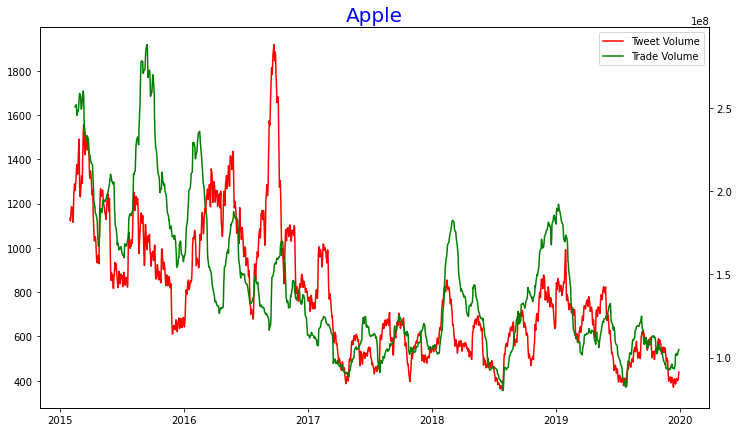

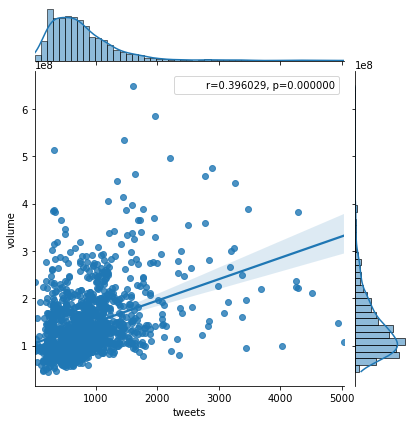

In [36]:
volume_tweet_impact('AAPL','Apple')
s_corr('AAPL','Apple')

Similarly lets try for Tesla

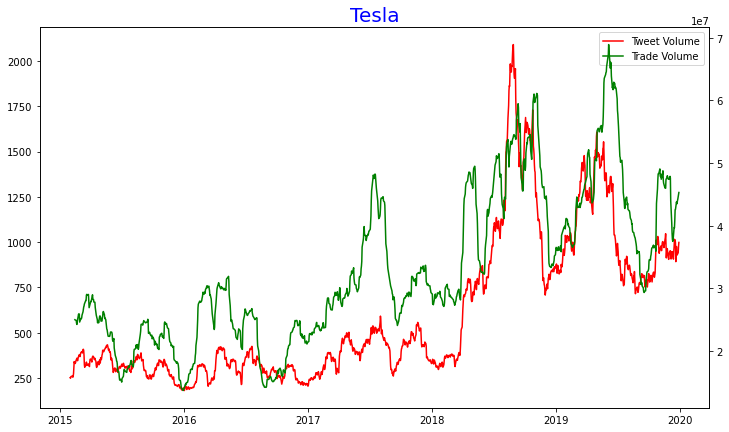

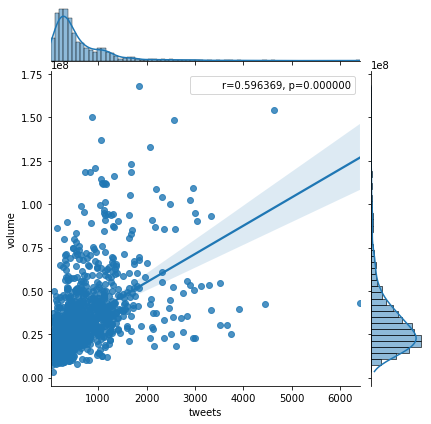

In [37]:
volume_tweet_impact('TSLA','Tesla')
s_corr('TSLA','Tesla')

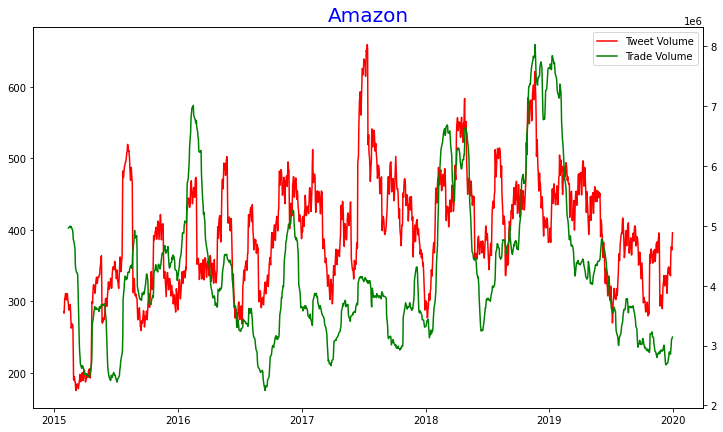

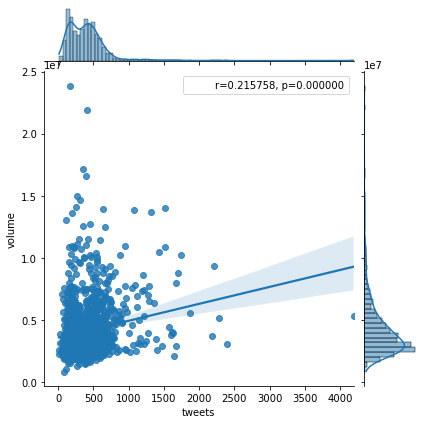

In [38]:
volume_tweet_impact('AMZN','Amazon')
s_corr('AMZN','Amazon')

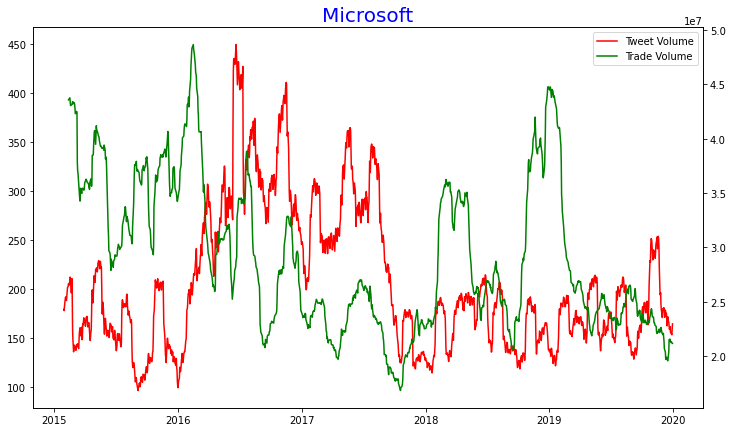

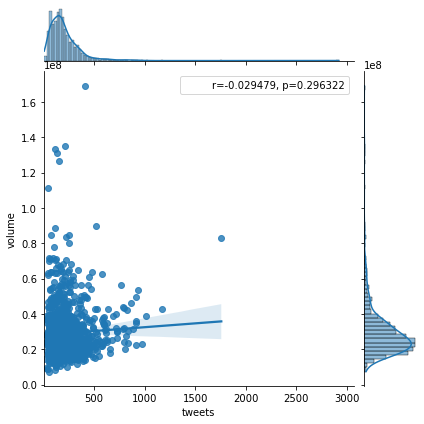

In [39]:
volume_tweet_impact('MSFT','Microsoft')
s_corr('MSFT','Microsoft')

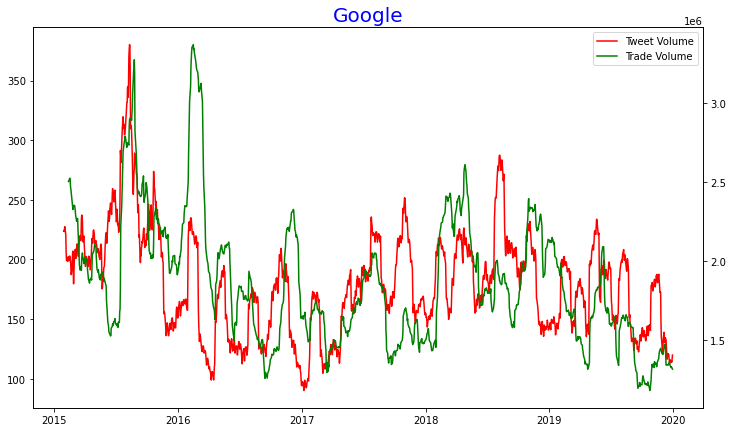

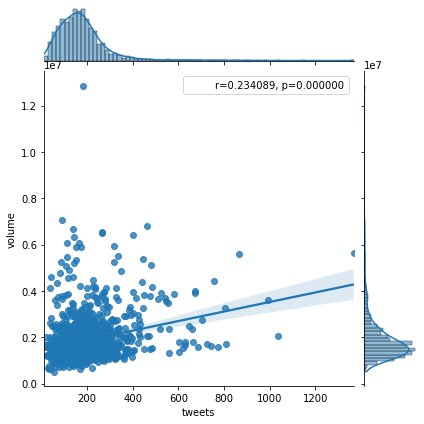

In [40]:
volume_tweet_impact('GOOGL','Google')
s_corr('GOOGL','Google')

It looks like the volume of tweets  has a positive correlation with the trade volume. However, the strength of the correlation is relatively low. Additionally, it is not certain that volume of tweets is always correlated with the share price as demostrated in Mircosoft's case where the p-value exceeded the predetermined threshold of 0.05. The significance of values observed  above the threshold means the relationship is not statistically significant.This means that the Hypothesis is rejected and the null Hypothesis is accepted.

Next we will analyze how the sentiment of the tweets impact the stock price.We will categorize the tweet sentiments as either positive, negative or neutral.

**H<sub>null</sub>**: The sentiment of the tweet has no correlation with the shareprice of the company.

**H<sub>alternative</sub>**: The sentiment of the tweet has a correlation with the shareprice of the company.


We will use Vader sentiment analysis model to get the tweet sentiments

In [41]:
def sentiments(ticker):
    tweet_news = tweet_combined[tweet_combined['ticker_symbol']== ticker].reset_index(drop=True)
    
    
    
    analyzer = SentimentIntensityAnalyzer()
    tweet_scores = []
    compound = []


    for i in range(tweet_news['body'].shape[0]):
        compound = analyzer.polarity_scores(tweet_news['body'].iloc[i])['compound']

        tweet_scores.append({"score": compound
                      }) 
    sentiments_score = pd.DataFrame.from_dict(tweet_scores)
    tweet_news = pd.merge(tweet_news, sentiments_score, left_index=True, right_index=True)
    tweet_news = tweet_news.drop(['post_date','writer','ticker_symbol','body', 'comment_num','retweet_num','like_num'], axis = 1)
    tweet_news =tweet_news.groupby('Date')["score"].mean().reset_index()
    for i, row in tweet_news.iterrows():
        if tweet_news.loc[i,'score'] > 0:
            tweet_news.loc[i,'sentiment'] = 1
        else:
            tweet_news.loc[i,'sentiment'] = -1
    return(tweet_news)


We will use the same method as before to test the hypothesis

In [42]:
def sentiment_overtime(stock_sentiment,ticker,title):
    stock_data = stock_hist.loc[stock_hist['ticker']==ticker,['Open']].dropna()
    corr_test = stock_sentiment.groupby('Date')['score'].mean().shift(-1).dropna()
    corr,pval = stats.spearmanr(corr_test.reindex(stock_data.index), stock_data['Open'],nan_policy='omit')
    visual= stock_sentiment.groupby('Date')['score'].mean().shift(-1).rolling(30).mean().dropna()
   
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot()
    ax2 = fig.add_subplot()
    ax2 = ax1.twinx()
    
    ax1.plot(visual.index,visual,label='Tweets Sentiment')
    ax2.plot(stock_data.index,stock_data['Open'],color='orange',label='share price')
    ax2.set_title("Effects of "+title+" tweets to shareprice" +"\n Spearman correlation: corr={0:.5f} pval={1:.5f}".format(corr,pval))
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.show()

In [43]:
sentiments_tsla = sentiments('TSLA')

<ipython-input-42-9dd6718e23d5>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot()


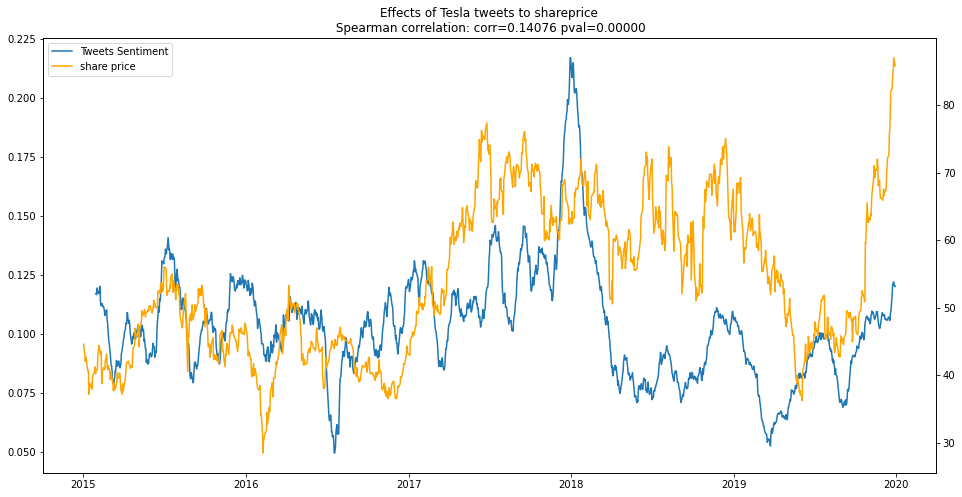

In [44]:
sentiment_overtime(sentiments_tsla,'TSLA',"Tesla")

Text(0.5, 1.0, 'Probability Distribution of TSLA Sentiment Scores by VADER')

<Figure size 720x504 with 0 Axes>

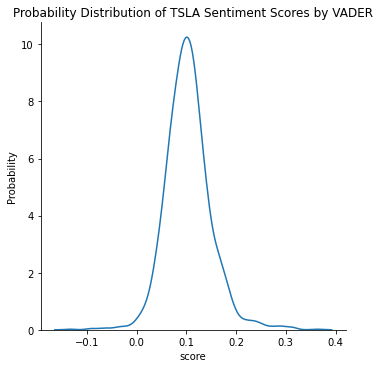

In [45]:
plt.figure(figsize=(10, 7))
sns.displot(data=sentiments_tsla,x='score',kind='kde')
plt.ylabel('Probability')
plt.title('Probability Distribution of TSLA Sentiment Scores by VADER')

<ipython-input-42-9dd6718e23d5>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot()


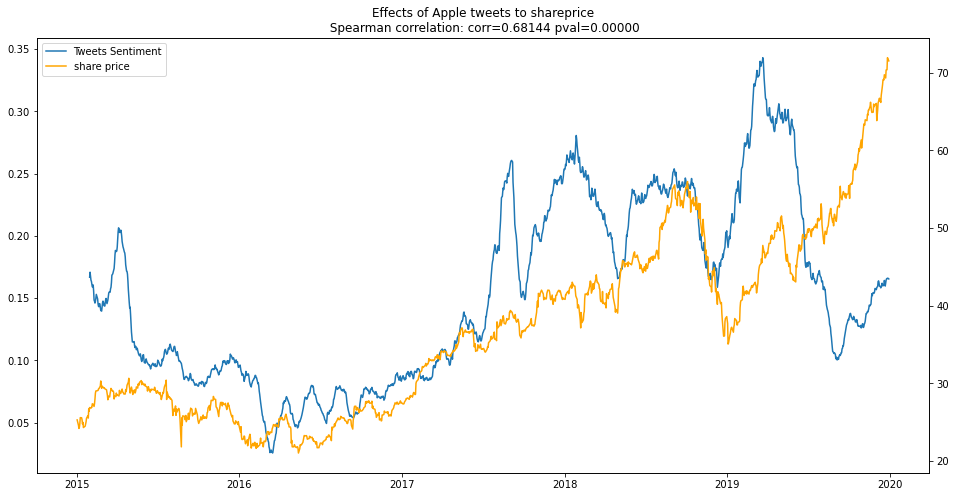

In [46]:
sentiments_aapl = sentiments('AAPL')
sentiment_overtime(sentiments_aapl,'AAPL',"Apple")

Text(0.5, 1.0, 'Probability Distribution of Apple Sentiment Scores by VADER')

<Figure size 720x504 with 0 Axes>

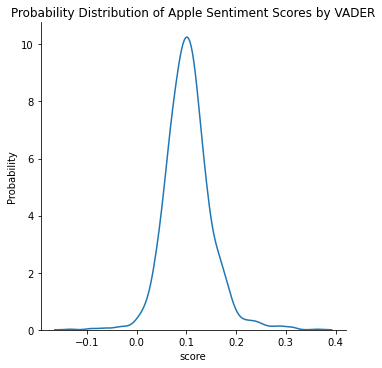

In [47]:
plt.figure(figsize=(10, 7))
sns.displot(data=sentiments_tsla,x='score',kind='kde')
plt.ylabel('Probability')
plt.title('Probability Distribution of Apple Sentiment Scores by VADER')

<ipython-input-42-9dd6718e23d5>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot()


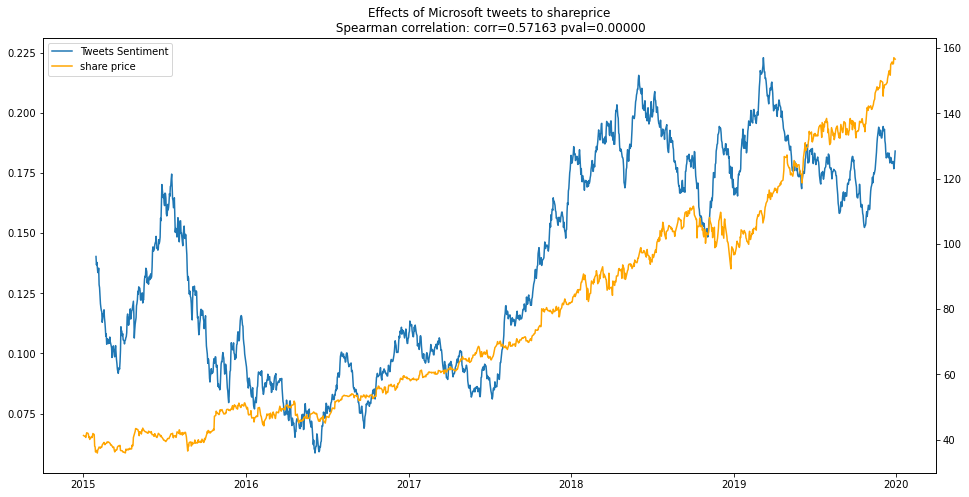

In [48]:
sentiments_msft = sentiments('MSFT')
sentiment_overtime(sentiments_msft,'MSFT','Microsoft')

<ipython-input-42-9dd6718e23d5>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot()


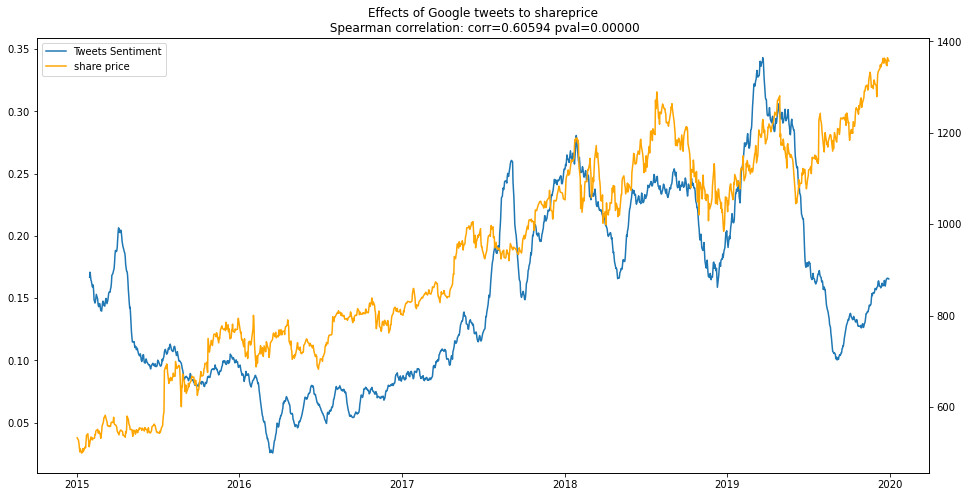

In [49]:
sentiments_googl = sentiments('GOOGL')
sentiment_overtime(sentiments_aapl,'GOOGL',"Google")

<ipython-input-42-9dd6718e23d5>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot()


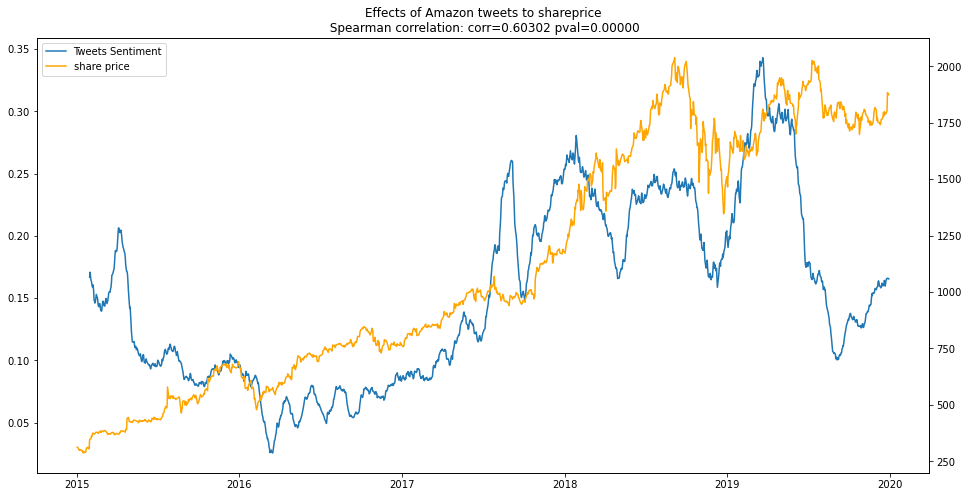

In [50]:
sentiments_amzn = sentiments('AMZN')
sentiment_overtime(sentiments_aapl,'AMZN',"Amazon")

There seems to be a stronger correlation between the sentiment of the tweets and the share price of the company as compared to the previous hypothesis.

Let's perform a time series analysis to see if we can use twitter sentiments to predict stcok prices
We will build the following models*
#### ARIMA
#### Facebook Prophet
#### Vector Autoregression(VAR)

In [51]:
stock_hist.reset_index(inplace=True)
stock_hist.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
0,2015-01-02,44.574001,44.650002,42.652000,43.862000,23822000,0.0,0.0,TSLA
1,2015-01-05,42.910000,43.299999,41.431999,42.018002,26842500,0.0,0.0,TSLA
2,2015-01-06,42.012001,42.840000,40.841999,42.256001,31309500,0.0,0.0,TSLA
3,2015-01-07,42.669998,42.956001,41.956001,42.189999,14842000,0.0,0.0,TSLA
4,2015-01-08,42.562000,42.759998,42.001999,42.124001,17212500,0.0,0.0,TSLA


In [52]:
#Split the stock information into train and test data
def stock_by_ticker(ticker,label):
    stock_details = stock_hist.loc[stock_hist['ticker']==ticker,['Date','Open']]
    train_data, test_data = stock_details[0:int(len(stock_details)*0.8)], stock_details[int(len(stock_details)*0.8):]
    train_data = train_data.set_index('Date', drop= False)
    test_data = test_data.set_index('Date', drop= False)
    
    plt.figure(figsize=(12,7))
    plt.title(label+ 'Stock Price')
    plt.xlabel('Years')
    plt.ylabel('Prices')
    plt.plot(train_data['Open'], 'blue', label='Training Data')
    plt.plot(test_data['Open'], 'red', label='Testing Data')
    plt.legend()
    print(f"Train Data Shape: {train_data.shape}")
    print(f"Test Data Shape: {test_data.shape}")
    return train_data,test_data
    
    


Train Data Shape: (1005, 2)
Test Data Shape: (252, 2)


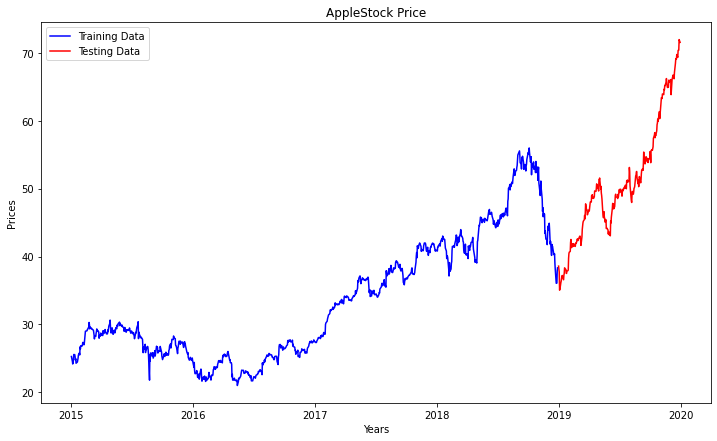

In [53]:
train_data,test_data = stock_by_ticker('AAPL','Apple')

In [54]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1005 entries, 2015-01-02 to 2018-12-28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1005 non-null   datetime64[ns]
 1   Open    1005 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.6 KB


#### There are three basic criterion for a time series to understand whether it is stationary series or not. Statistical properties of time series such as mean, variance should remain constant over time to call time series is stationary.

#### Following are the 3 qualities of a stationary time series:

* Constant mean

* Constant variance

* Autocovariance that does not depend on time. Autocovariance is covariance between time series and lagged time series.

#### Let's visualize and check seasonality and trend of our time series first.


Text(0.5, 0, 'Years')

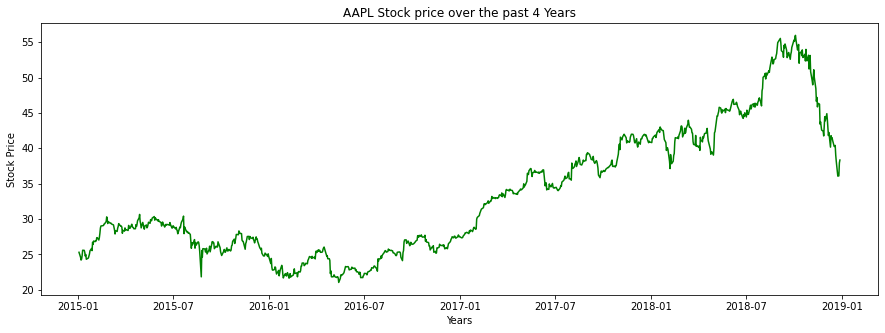

In [55]:
#Visualize stock data over the past years
plt.figure(figsize=(15, 5))
plt.plot(train_data.Open, color='green')
plt.title("AAPL Stock price over the past 4 Years")
plt.ylabel("Stock Price")
plt.xlabel("Years")

*Trend:*  This timeseries shows an upward trend. This is a non-stationary time series. We need to convert it to stationary to forecast accurately. Let's also check for the seasonality.

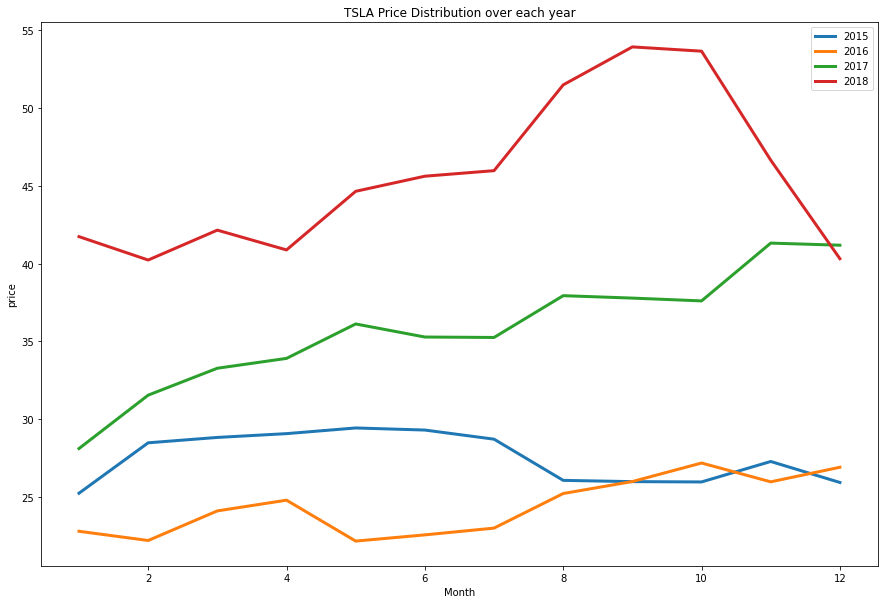

In [56]:
season = train_data
season['Date'] = train_data.Date
season['Year'] = train_data['Date'].dt.year
season['Month'] = train_data['Date'].dt.month
spivot = pd.pivot_table(season, index='Month', columns = 'Year', values = 'Open')
spivot.plot(figsize=(15,10), linewidth=3)
plt.legend(loc = 'upper right')
plt.ylabel('price')
plt.title('TSLA Price Distribution over each year')
plt.show()

Seasonality: The timeseries has a slight seasonal variation.

We can observe that the stock price increases in the later half of the year. 

Now let's check stationarity of time series. We can check stationarity using the following methods:

    Plotting Rolling Statistics: We have a window lets say window size is 6 and then we find rolling mean and variance to check stationary.
    Dickey-Fuller Test: The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the test statistic is less than the critical value, we can say that time series is stationary. Here we state Null Hypothesis that our timeseries is non-stationary and the alternate hypothesis that the timeseries is stationary.

For timeseries to be stationary we should get a p-value of less than 5% to reject the null hypothesis.


In [57]:
#Reference: https://www.kaggle.com/kanncaa1/time-series-prediction-tutorial-with-eda

ts = train_data['Open']
date = train_data['Date']

In [58]:
# Adfuller Test

def adfuller_test(ts, signif=0.05, name='Stock Price', verbose=False):
#Perform ADFuller to test for Stationarity of given series and print report
    r = adfuller(ts, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 


In [59]:
# check_mean_std
def check_mean_std(ts):
    
    #Rolling statistics
    rolmean = ts.rolling(6).mean()
    rolstd = ts.rolling(6).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Years")
    plt.ylabel("Price")
    plt.title('Rolling Mean and Rolling Std. on AAPL Stock Price Data')
    plt.legend()
    plt.show()

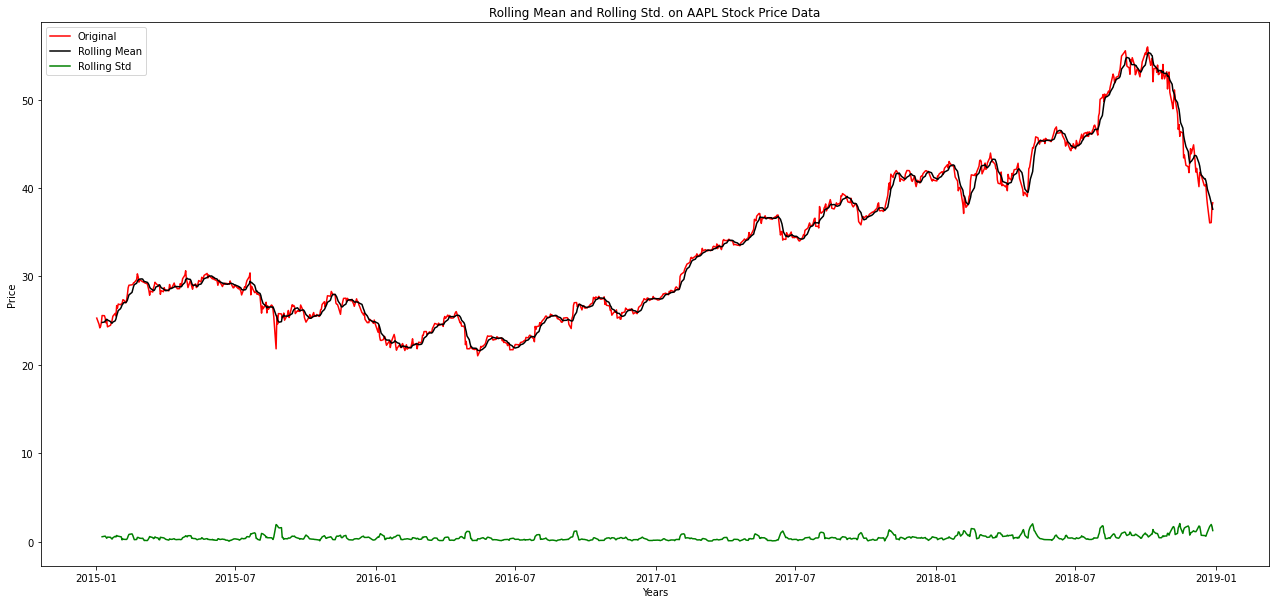

    Augmented Dickey-Fuller Test on "Stock Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4224
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.5715. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [60]:
# check stationary: mean, variance(std) and adfuller test on train data
check_mean_std(ts)
#check_adfuller(ts)
adfuller_test(ts)

Our first criteria for stationary is constant mean. So we fail because mean is not constant as you can see from plot (black line) above.

Second one is constant variance. It looks like constant. (Green Graph above)

Third one is that if the test statistic is less than the critical value, we can say that time series is stationary.

Lets look: test statistic = 0.674 and critical values = {'1%': -3.431667761145687, '5%': -2.8621223070279247, '10%': -2.5670799628923104}. Test statistic is bigger than the critical values. So, no stationary.

As a result, we are sure that our time series is not stationary. Lets make time series stationary at the next part.

We can do so with the help of:

* Moving Average Method
* Differencing Method

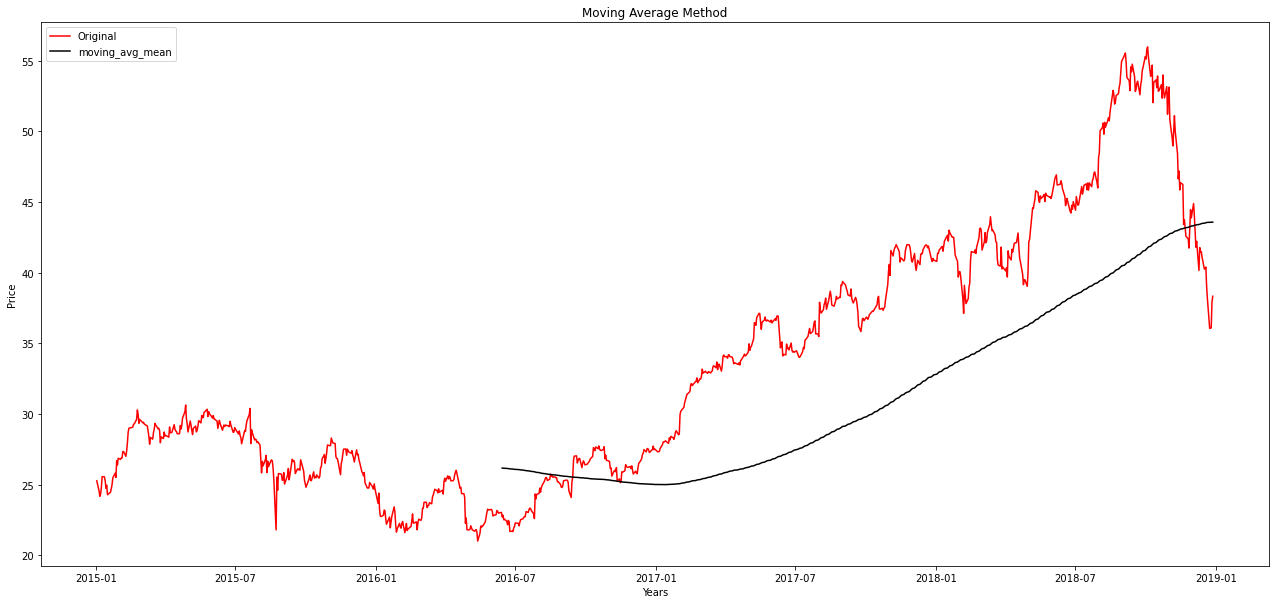

In [61]:
# Moving average method
window_size = 365
moving_avg = ts.rolling(window_size).mean()
plt.figure(figsize=(22,10))
plt.plot(ts, color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "moving_avg_mean")
plt.title("Moving Average Method")
plt.xlabel("Years")
plt.ylabel("Price")
plt.legend()
plt.show()

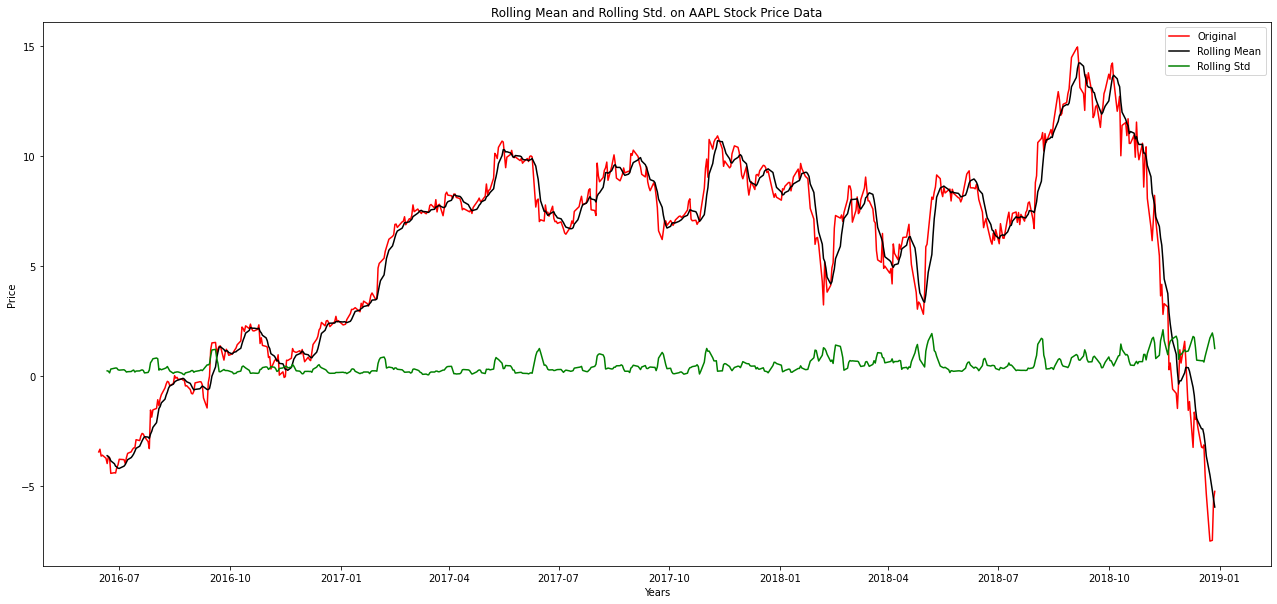

    Augmented Dickey-Fuller Test on "Stock Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8403
 No. Lags Chosen       = 10
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.3606. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [62]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace=True) # first 3 is nan value due to window size
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_moving_avg_diff)
adfuller_test(ts_moving_avg_diff)

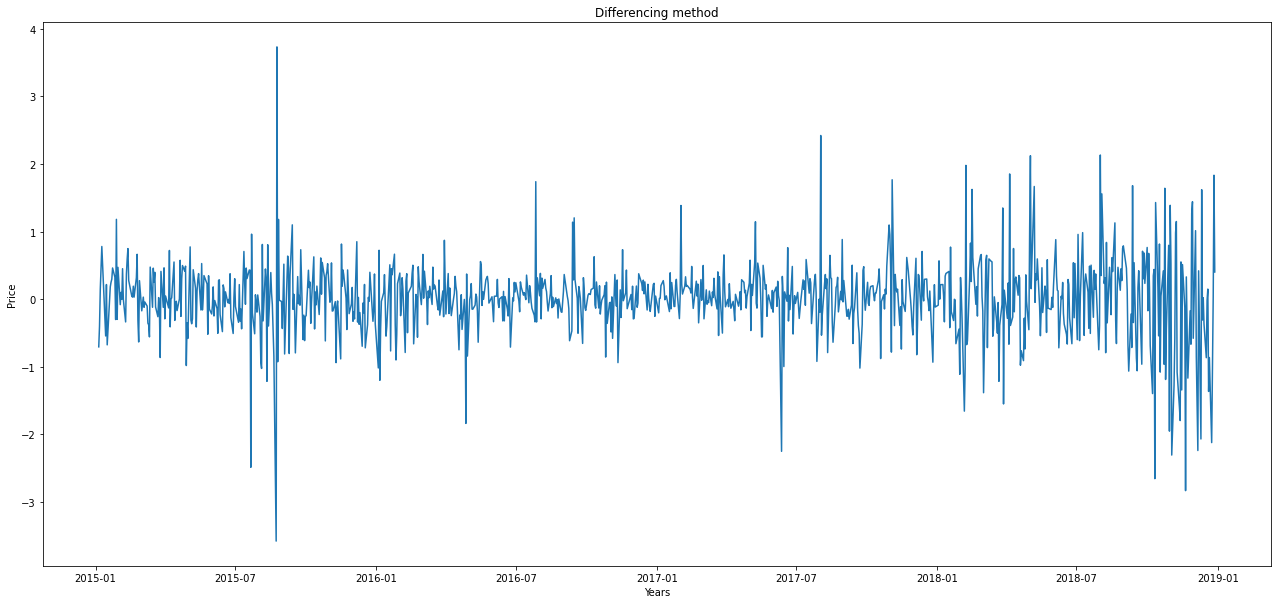

In [63]:
#Differencing method

#Shifting by 1 period
ts_diff = ts - ts.shift(1)
plt.figure(figsize=(22,10))
plt.plot(ts_diff)
plt.title("Differencing method") 
plt.xlabel("Years")
plt.ylabel("Price")
plt.show()

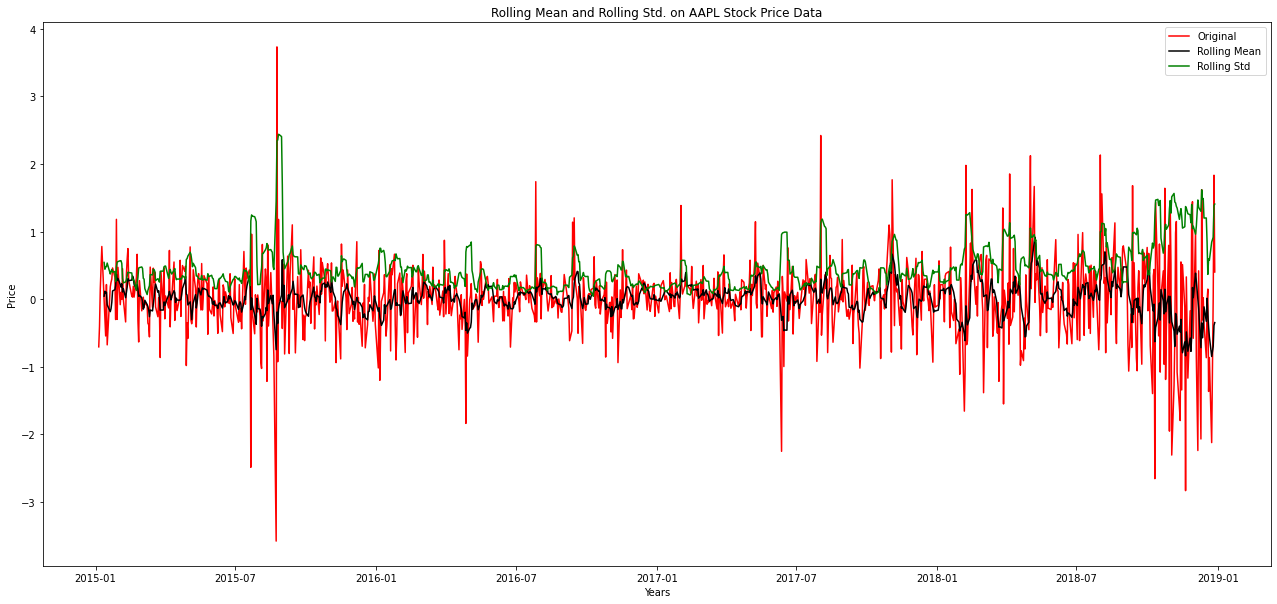

    Augmented Dickey-Fuller Test on "Stock Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8086
 No. Lags Chosen       = 21
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


In [64]:
ts_diff.dropna(inplace=True) # due to shifting there is nan values
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_diff)
#check_adfuller(ts_diff)
adfuller_test(ts_diff)

Now there is no trend visible,our time series is almost stationary now. We can use this time series for forecasting.

## 1. ARIMA

In [65]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

/Users/balaji/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Partial Autocorrelation Function')

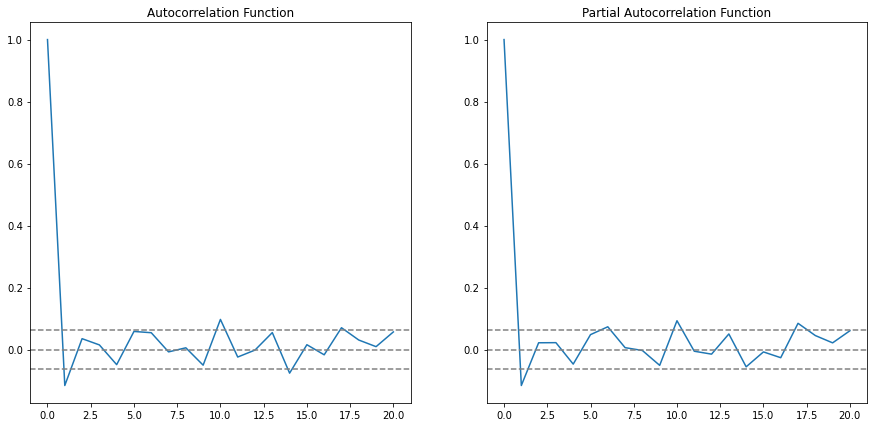

In [66]:
plt.figure(figsize=(15,7))

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1.

d - In differencing method, shift of 1 period produced a stationary timer series. So we will use d = 1.


In [67]:
from statsmodels.tsa.arima_model import ARIMA

/Users/balaji/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/balaji/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it h

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                 1004
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -847.455
Method:                       css-mle   S.D. of innovations              0.563
Date:                Mon, 07 Jun 2021   AIC                           1702.910
Time:                        08:33:55   BIC                           1722.557
Sample:                             1   HQIC                          1710.376
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0130      0.016      0.810      0.418      -0.019       0.045
ar.L1.D.Open    -0.2343      0.200     -1.170      0.242      -0.627       0.158
ma.L1.D.Open     0.1194      0.204      0.58

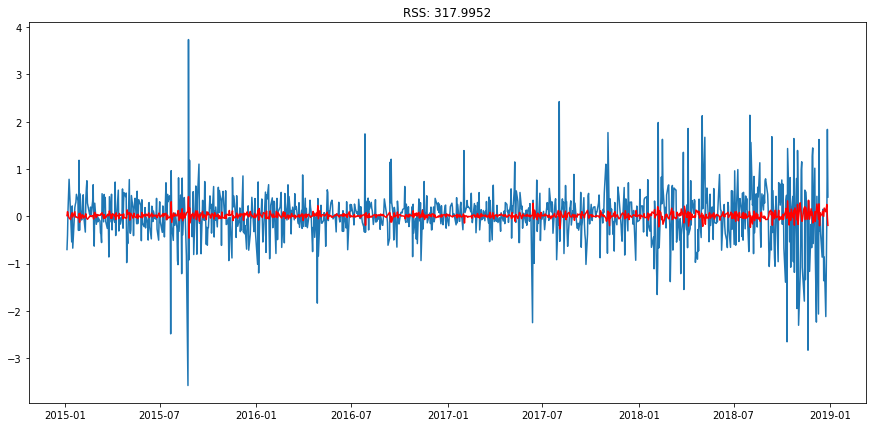

In [68]:
plt.figure(figsize=(15,7))

model = ARIMA(ts, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_diff)**2))

print(results_ARIMA.summary())

**Predicting Train Data**

In [69]:
yhat = results_ARIMA.predict(1, 1005)

/Users/balaji/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [70]:
yhat.head()

0    0.013044
1    0.096567
2    0.050221
3   -0.007108
4   -0.035994
dtype: float64

In [71]:
predictions_ARIMA_diff_cumsum = yhat.cumsum() + train_data['Open'][0]
print (predictions_ARIMA_diff_cumsum.head())
print (predictions_ARIMA_diff_cumsum.tail())

0    25.299929
1    25.396496
2    25.446717
3    25.439609
4    25.403616
dtype: float64
1000    38.368946
1001    38.617333
1002    38.599585
1003    38.406959
1004    38.399634
dtype: float64


Let's plot the results from ARIMA

RMSE_ARIMA = 6.876440761288353


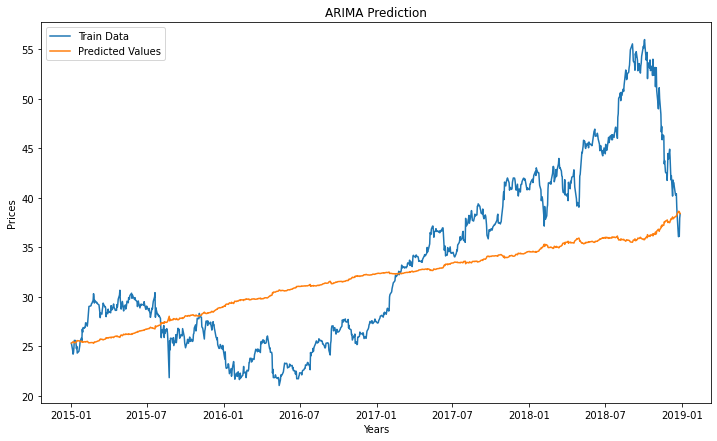

In [72]:
#Predicting Train Data
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = pd.DataFrame(predictions_ARIMA_diff_cumsum.values)
predictions.set_index(train_data.index, inplace = True)

plt.figure(figsize=(12,7))

plt.plot(train_data['Open'], label = 'Train Data')
plt.plot(predictions, label = 'Predicted Values')
plt.title('ARIMA Prediction')
plt.xlabel('Years')
plt.ylabel('Prices')
plt.legend()

RMSE_ARIMA = sqrt(mean_squared_error(train_data['Open'].values, predictions_ARIMA_diff_cumsum.values))

print(f"RMSE_ARIMA = {RMSE_ARIMA}")

#### ARIMA Forcasting

In [73]:
len(train_data), len(test_data)

(1005, 252)

In [74]:
yhat = results_ARIMA.predict(1005, 1005+251)

/Users/balaji/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [75]:
yhat.head()

1004   -0.007325
1005    0.017816
1006    0.011926
1007    0.013306
1008    0.012983
dtype: float64

In [76]:
predictions_ARIMA_diff_cumsum = yhat.cumsum() + train_data['Open'][-1]
print (predictions_ARIMA_diff_cumsum.head())
print (predictions_ARIMA_diff_cumsum.tail())

1004    38.330181
1005    38.347996
1006    38.359922
1007    38.373228
1008    38.386211
dtype: float64
1251    41.555906
1252    41.568950
1253    41.581994
1254    41.595038
1255    41.608082
dtype: float64


Let's plot the final results from ARIMA

RMSE_ARIMA = 13.381881425647228


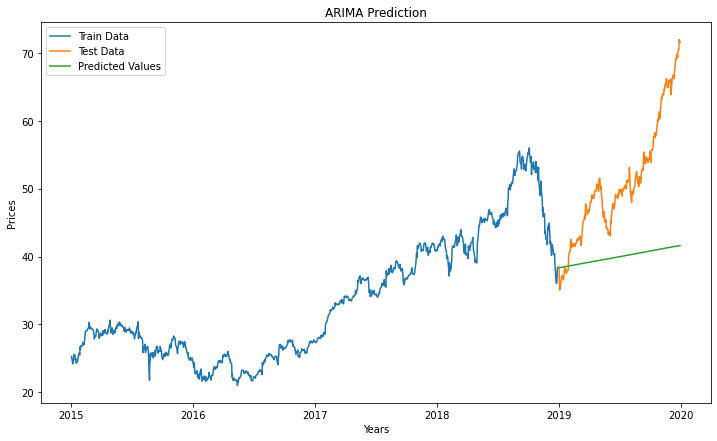

In [77]:
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = pd.DataFrame(predictions_ARIMA_diff_cumsum.values)
predictions.set_index(test_data.index, inplace = True)

plt.figure(figsize=(12,7))

plt.plot(train_data['Open'], label = 'Train Data')
plt.plot(test_data['Open'], label = 'Test Data')
plt.plot(predictions, label = 'Predicted Values')
plt.title('ARIMA Prediction')
plt.xlabel('Years')
plt.ylabel('Prices')
plt.legend()

RMSE_ARIMA = sqrt(mean_squared_error(test_data['Open'].values, predictions_ARIMA_diff_cumsum.values))

print(f"RMSE_ARIMA = {RMSE_ARIMA}")

We have got RMSE: 13.02 from ARIMA Model. Let's see if we can improve this.

## 2.FACEBOOK PROPHET

In [78]:
# Rename the features: These names are required for the model fitting
ts = train_data.rename(columns = {"Date":"ds","Open":"y"})

In [79]:
from prophet import Prophet
# the Prophet class (model)
m = Prophet(daily_seasonality = True) 
# fit the model using all data
m.fit(ts) 

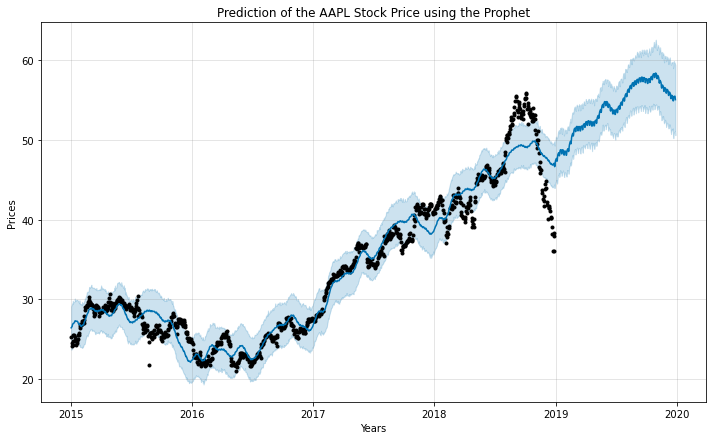

In [80]:
#we need to specify the number of days in future
future = m.make_future_dataframe(periods=365) 
prediction = m.predict(future)
m.plot(prediction)

plt.title("Prediction of the AAPL Stock Price using the Prophet")
plt.xlabel("Years")
plt.ylabel("Prices")
plt.show()

In [81]:
yhat = prediction['yhat'].tail(252)

Plot looks good. It shows the confidence interval as well. However, let's compare it with our test_data and find RMSE.

RMSE_Prophet = 9.182053476999368


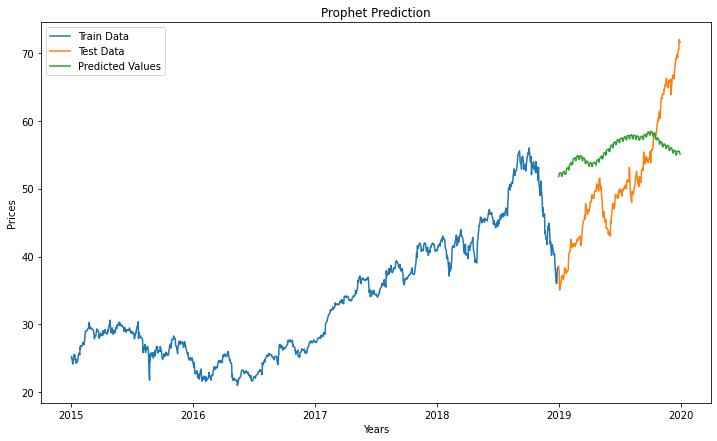

In [82]:
predictions = pd.DataFrame(yhat)
predictions.set_index(test_data.index, inplace = True)

plt.figure(figsize=(12,7))

plt.plot(train_data['Open'], label = 'Train Data')
plt.plot(test_data['Open'], label = 'Test Data')
plt.plot(predictions, label = 'Predicted Values')
plt.title('Prophet Prediction')
plt.xlabel('Years')
plt.ylabel('Prices')
plt.legend()

RMSE_Prophet = sqrt(mean_squared_error(test_data['Open'].values, yhat))

print(f"RMSE_Prophet = {RMSE_Prophet}")

**Plot the trend, weekly, seasonally, yearly and daily components**

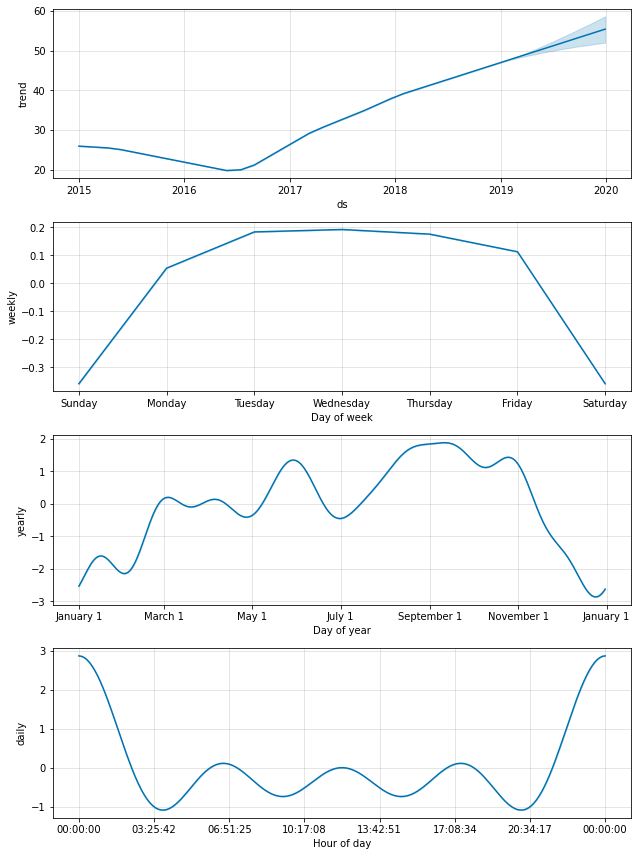

In [83]:
m.plot_components(prediction)
plt.show()

## Model 3. Vector Autoregression

In [84]:
def stock_ticker(ticker):
    stock_details = stock_hist.loc[stock_hist['ticker']==ticker,['Date','Open']]
    return stock_details

In [85]:
stock_detail = stock_ticker('AAPL')

In [86]:
sentiments_shifted_by_day = sentiments_tsla.shift(-1).dropna()
data= pd.merge(stock_detail,sentiments_shifted_by_day, on="Date")

In [87]:
df1 = data[['Date','score', 'Open']]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1257 entries, 0 to 1256
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1257 non-null   datetime64[ns]
 1   score   1257 non-null   float64       
 2   Open    1257 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 39.3 KB


In [88]:
df1.set_index('Date', inplace = True)

In [89]:
from statsmodels.tsa.api import VAR

**Testing Causation using Granger’s Causality Test**

Using Granger’s Causality Test, let's test this relationship before even building the model. The null hypothesis here is that the coefficients of past values in the regression equation is zero.

Check Granger Causality of all possible combinations of the Time series. The rows are the response variable, columns are predictors. The values in the table are the P-Values. P-Values lesser than the significance level (0.05), implies the Null Hypothesis that the coefficients of the corresponding past values is zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.

In [90]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df1 = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df1.columns:
        for r in df1.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df1.loc[r, c] = min_p_value
    df1.columns = [var + '_x' for var in variables]
    df1.index = [var + '_y' for var in variables]
    return df1

grangers_causation_matrix(df1, variables = df1.columns) 

,score_x,Open_x
score_y,1.0000,0.4327
Open_y,0.2344,1.0000


Since the p-value is < significance level (0.05),we can say twitter sentiment impacts the stock price and we can reject the null hypothesis.

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

In [91]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def adjust(val, length= 6): return str(val).ljust(length)
def cointegration_test(df1, alpha=0.05): 
    out = coint_johansen(df1,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df1.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df1)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
score  ::  43.92     > 12.3212   =>   True
Open   ::  5.98      > 4.1296    =>   True


**Split the Series into Training and Testing Data**

In [92]:
df_train, df_test = df1[0:int(len(df1)*0.8)], df1[int(len(df1)*0.8):]
print(df_train.shape)
print(df_test.shape)

(1005, 2)
(252, 2)


**Check for Stationarity and Make the Time Series Stationary**

In [93]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "score" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1845
 No. Lags Chosen       = 6
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4224
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.5715. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




The AAPL stock price is not stationary.

All of the series in the VAR model should have the same number of observations. Let’s difference.

In [94]:
df_differenced = df_train.diff().dropna()

In [95]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "score" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.6612
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8086
 No. Lags Chosen       = 21
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.




The series are stationary now.

**Select the Order (P) of VAR model**

In [96]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -7.505857629697766
BIC :  -7.4764812540967975
FPE :  0.0005498540965009614
HQIC:  -7.494694180633842 

Lag Order = 2
AIC :  -7.610349929913932
BIC :  -7.561350396164982
FPE :  0.0004952985904422373
HQIC:  -7.591728494133403 

Lag Order = 3
AIC :  -7.623798498082926
BIC :  -7.555144585085511
FPE :  0.0004886822661722291
HQIC:  -7.597706486448179 

Lag Order = 4
AIC :  -7.64601883298212
BIC :  -7.557679237960442
FPE :  0.0004779435823788408
HQIC:  -7.612443622561141 

Lag Order = 5
AIC :  -7.669720663674814
BIC :  -7.561664001882754
FPE :  0.00046674901609131754
HQIC:  -7.6286495976173585 

Lag Order = 6
AIC :  -7.684282539404048
BIC :  -7.5564773438288
FPE :  0.00046000205912883626
HQIC:  -7.635702926817227 

Lag Order = 7
AIC :  -7.6801144550947
BIC :  -7.532529176159038
FPE :  0.0004619241241861211
HQIC:  -7.624013570917992 

Lag Order = 8
AIC :  -7.680285274278022
BIC :  -7.512888279541198
FPE :  0.00046184619054505307
HQIC:  -7.616650359157706 

Lag Order = 9
AI

/Users/balaji/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


AIC is progressively decresing and then at some point it increases.Let’s go with the lag 3 model.

**Train the VAR Model of Selected Order(p)**

In [97]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Jun, 2021
Time:                     08:34:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.55514
Nobs:                     1001.00    HQIC:                  -7.59771
Log likelihood:           988.996    FPE:                0.000488682
AIC:                     -7.62380    Det(Omega_mle):     0.000481919
--------------------------------------------------------------------
Results for equation score
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.000029         0.001232            0.023           0.981
L1.score        -0.553252         0.031397          -17.621           0.000
L1.Open         -0.000101         0.002190           -0.046           0.963
L2.s

**Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic**

In [98]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df1.columns, out):
    print(adjust(col), ':', round(val, 2))

score  : 2.05
Open   : 2.0


The serial correlation seems alright. Let’s proceed with the forecast.

**Forecast VAR model using statsmodels**

In [99]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[ 0.01213621,  0.03651936],
       [-0.05131048,  1.83533243],
       [ 0.04198524,  0.4040704 ]])

**Forecast**

In [100]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=252)
df_forecast = pd.DataFrame(fc, index=df1.index[-252:], columns=df1.columns + '_1d')
df_forecast

,score_1d,Open_1d
Date,,
2018-12-31,-0.010368,0.011429
2019-01-02,-0.004935,0.062506
2019-01-03,0.000633,0.029674
2019-01-04,0.002928,0.005293
2019-01-07,-0.001229,0.016353
...,...,...
2019-12-23,-0.000009,0.014102
2019-12-24,-0.000009,0.014102
2019-12-26,-0.000009,0.014102


The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, you need to de-difference it as many times you had differenced the original input data.

**Invert the transformation to get the real forecast**

In [101]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
       # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


In [102]:
df_results = invert_transformation(df_train, df_forecast)        
df_results.loc[:, ['score_1d', 'Open_1d']]

,score_1d,Open_1d
Date,,
2018-12-31,-0.010368,0.011429
2019-01-02,-0.004935,0.062506
2019-01-03,0.000633,0.029674
2019-01-04,0.002928,0.005293
2019-01-07,-0.001229,0.016353
...,...,...
2019-12-23,-0.000009,0.014102
2019-12-24,-0.000009,0.014102
2019-12-26,-0.000009,0.014102


**Plot of Forecast vs Actuals**

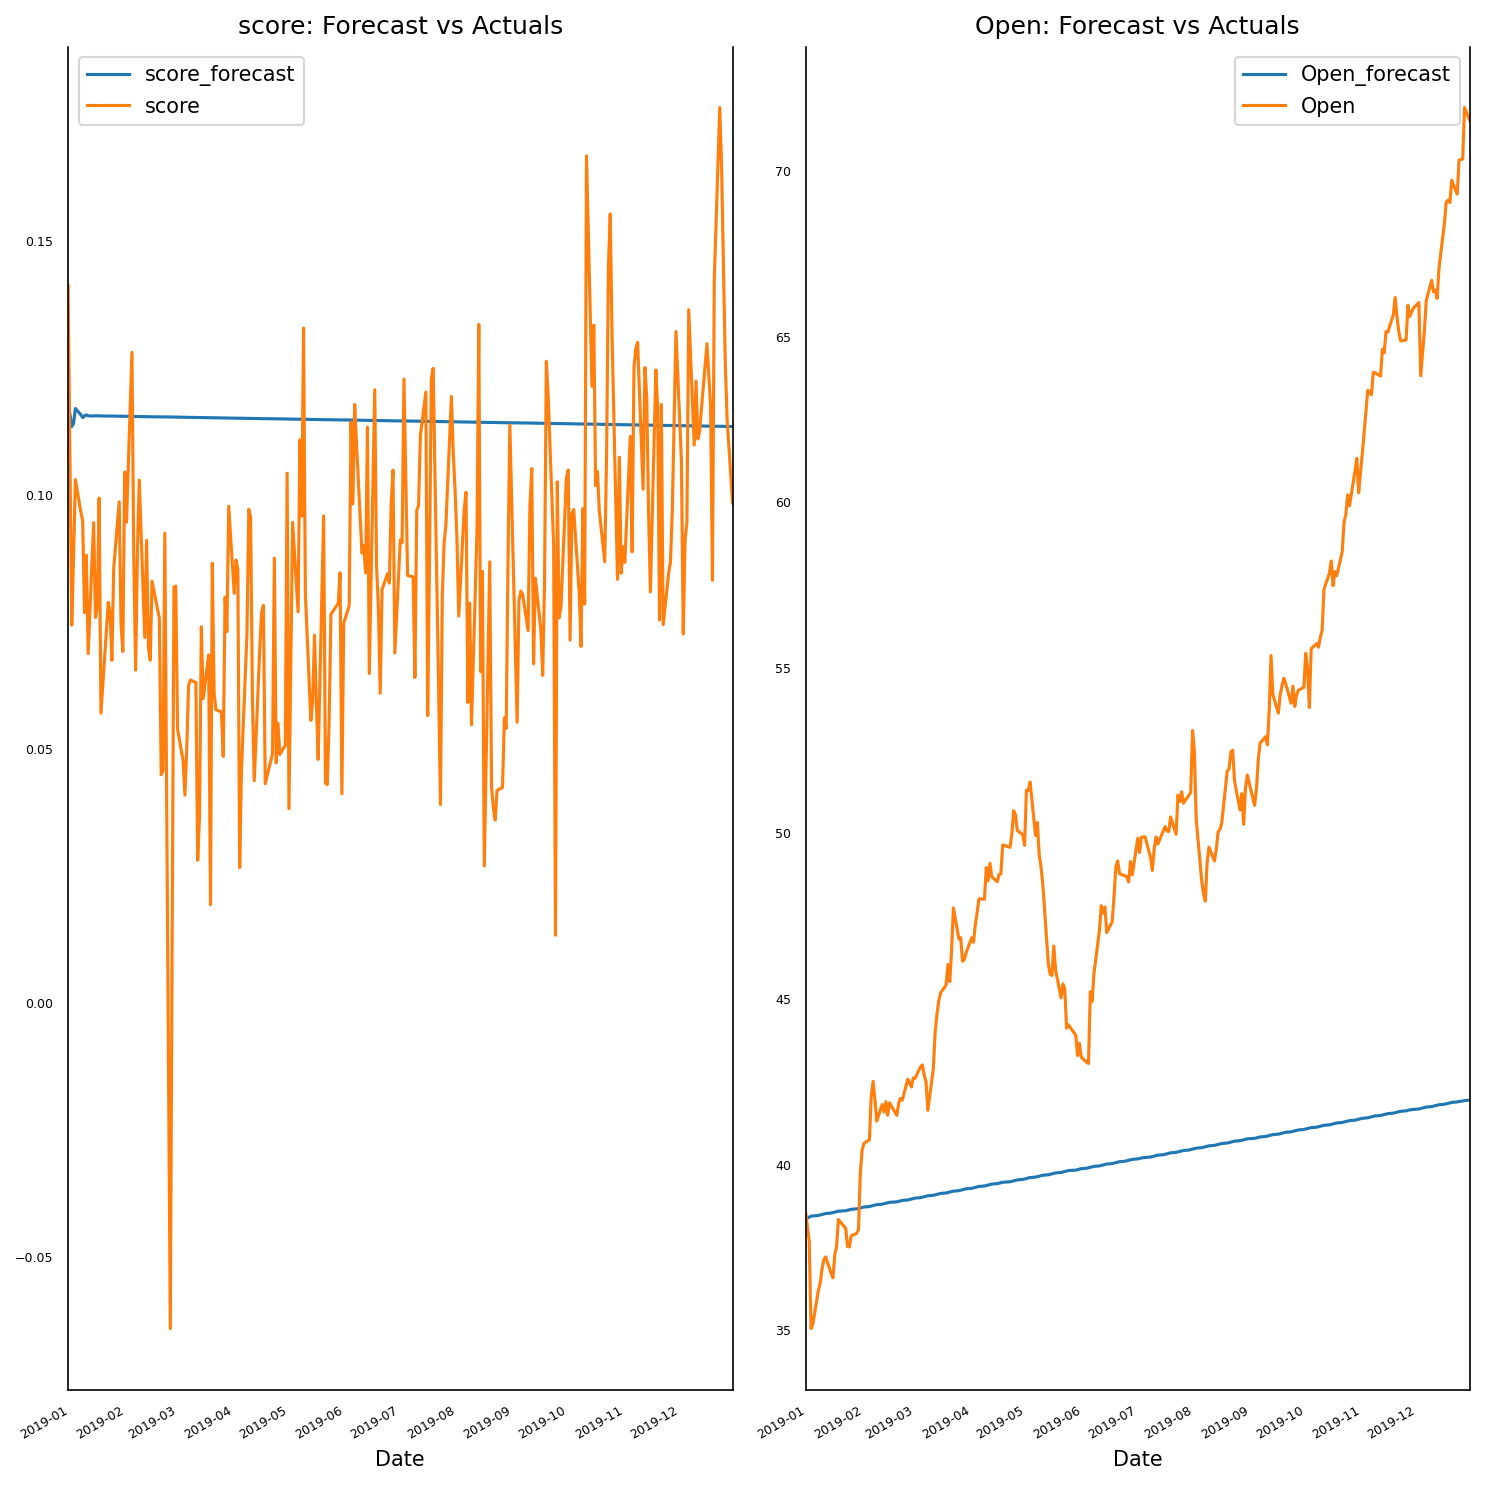

In [103]:
fig, axes = plt.subplots(nrows=int(len(df1.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df1.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-252:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

**Evaluate the Forecasts**

In [104]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'rmse_VAR':rmse})

print('\nForecast Accuracy of: stock price')
accuracy_prod = forecast_accuracy(df_results['Open_forecast'].values, df_test['Open'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: stock price
rmse_VAR :  13.1727


In [105]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "RMSE on Test Data"]

x.add_row(["ARIMA", 13.02])
x.add_row(["FB Prophet", 9.18])
x.add_row(["Vector Autoregression", 13.17])

print(x)

+-----------------------+-------------------+
|         Model         | RMSE on Test Data |
+-----------------------+-------------------+
|         ARIMA         |       13.02       |
|       FB Prophet      |        9.18       |
| Vector Autoregression |       13.17       |
+-----------------------+-------------------+


## Conclusion

Eventhough we found some correlation between stock price and tweet sentiments, when it comes to predicting the stock price this relatioship in inconclusive as we see from our model results.